# **Лабораторна робота №5**
### з дисципліни **"Інтелектуальні системи підтримки прийняття рішень"**

##### **За темою:** "Використання технологiї передачi знань для побудови моделi згорткових нейронних мереж в задачi класифiкацiї кольорових зображень"

##### **Варіант:** 17

##### **Виконав:** Гавлицький Іван, КА-12

##### **Перевірила:** Недашкiвська Н.I.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt 
import seaborn as sns

import time
import warnings
warnings.filterwarnings("ignore")
tf.get_logger().setLevel('ERROR')

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

### **Мета роботи:**
* Навчитися використовувати технологiю передачi знань (transfer learning) для побудови моделi згорткових нейронних мереж з метою класифiкацiї кольорових зображень.
* Навчитися створювати моделi згорткових нейронних мереж за допомогою бiблiотеки TensorFlow та API Keras.
* Використати згорткову нейронну мережу для класифiкацiї кольорових зображень.
* Для представлення результатiв використати TensorBoard.

### **Хід виконання роботи:**
1. Завантажити набiр кольорових зображень з попереднього практикуму згiдно з варiантом. Якщо набiр великого розмiру - можна обрати частину.
1. Пiдготувати данi для навчання. Виконати аугментацiю даних.
1. Роздiлити данi на навчальну, валiдацiйну i тестову пiдмножини.
1. Побудувати моделi класифiкацiї зображень на основi попередньо навчених глибоких згорткових мереж, використовуючи технологiю передачi знань (transfer learning):
    * Завантажити попередньо навченi ваги. Iмпортувати ваги, отриманi пiд час навчання обраних глибоких моделей на наборi зображень ImageNet.
    * Побудувати один або кiлька верхнiх повнозв’язних шарiв. Останнiм (результуючим) шаром мережi має бути повнозв’язний softmax-шар з кiлькiстю нейронiв, яка дорiвнює кiлькостi класiв в заданому за варiантом наборi даних.
    * Заморозити попередньо навченi ваги. Заморожуючи змiннi попередньої моделi ми гарантуємо, що буде навчатися тiльки один (кiлька) верхнiх повнозв’язних шарiв; значення попередньої моделi залишаться незмiнними.
    * Виконати донавчання доданих верхнiх шарiв на власному наборi зображень.
    * Налаштувати параметри доданих верхнiх шарiв на валiдацiйнiй пiдмножинi.

    Для дослiдження обрати кiлька попередньо навчених глибоких моделей, наприклад з наступних: VGG19, Xception, InceptionV3, ResNet152, DenseNet201, EfficientNetB7.
    
1. Вiдобразити у TensorBoard графiки, якi iлюструють оцiнки якостi навчання моделей:
    * графiки змiни функцiї втрат на тренувальнiй i валiдацiйнiй множинах по мiрi навчання моделей,
    * графiки змiни показникiв якостi моделi (accuracy, f1-score, AUC) на тренувальнiй i валiдацiйнiй множинах по мiрi навчання моделей.

6. Розрахувати на тестовiй множинi оцiнки якостi обраної найкращої моделi.

7. Завантажити зображення тестової множини i розпiзнати його навченими моделями.

8. Зробити висновки щодо якостi класифiкацiї на основi побудованих моделей. Порiвняти з результатами попереднього практикуму.

In [3]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# **Clothing Dataset:**

Вирішив взяти кольоровий датасет із попередньої лабораторної, адже із цим добре впорався навіть ***MLP***.

Використаємо відповідну генерацію даних, аби можна було коректно порівнювати результати з попередньою роботою.

In [4]:
IMAGE_SIZE = (224, 224)

## **Data Preprocessing**

In [5]:
df = pd.read_csv('../input/clothing-dataset-full/images.csv')
df = df[df['label'] != 'Skip'].copy()
df['filepath'] = df['image'].apply(
    lambda image: f"../input/clothing-dataset-full/images_compressed/{image}.jpg"
    )

df.head()

image  sender_id     label   kids  \
0  4285fab0-751a-4b74-8e9b-43af05deee22        124  Not sure  False   
1  ea7b6656-3f84-4eb3-9099-23e623fc1018        148   T-Shirt  False   
2  00627a3f-0477-401c-95eb-92642cbe078d         94  Not sure  False   
3  ea2ffd4d-9b25-4ca8-9dc2-bd27f1cc59fa         43   T-Shirt  False   
4  3b86d877-2b9e-4c8b-a6a2-1d87513309d0        189     Shoes  False   

                                            filepath  
0  ../input/clothing-dataset-full/images_compress...  
1  ../input/clothing-dataset-full/images_compress...  
2  ../input/clothing-dataset-full/images_compress...  
3  ../input/clothing-dataset-full/images_compress...  
4  ../input/clothing-dataset-full/images_compress...

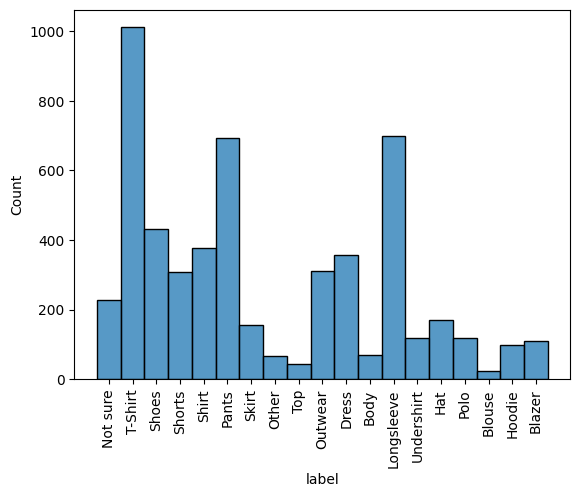

In [6]:
sns.histplot(df["label"])
plt.xticks(rotation=90)
plt.show()

### Split data into train, valid & test

In [7]:
from sklearn.model_selection import train_test_split

train_df, dummy_df = train_test_split(df,
                                      test_size=0.2,
                                      shuffle=True, random_state=42,
                                      stratify= df['label']
                                      )

valid_df, test_df = train_test_split(dummy_df,
                                     test_size=0.5,
                                     shuffle=True, random_state=42,
                                     stratify=dummy_df['label']
                                     )

In [8]:
print(f"Train shape = {train_df.shape}")
print(f"Valid shape = {valid_df.shape}")
print(f"Test shape = {test_df.shape}")

Train shape = (4312, 5)
Valid shape = (539, 5)
Test shape = (540, 5)


#### Image data generator

In [9]:
BATCH_SIZE = 32

train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_generator.flow_from_dataframe(
    train_df, 
    x_col='filepath', 
    y_col='label',
    class_mode='categorical', 
    color_mode='rgb',  
    batch_size=BATCH_SIZE,
    target_size=IMAGE_SIZE
)


validation_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_generator.flow_from_dataframe(
    valid_df,
    x_col='filepath', 
    y_col='label',
    class_mode='categorical', 
    color_mode='rgb',  
    batch_size=BATCH_SIZE,
    target_size=IMAGE_SIZE
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255)
test_generator = test_generator.flow_from_dataframe(
    test_df, 
    x_col='filepath', 
    y_col='label',
    class_mode='categorical', 
    color_mode='rgb',  
    batch_size=BATCH_SIZE,
    target_size=IMAGE_SIZE
)

Found 4311 validated image filenames belonging to 19 classes.
Found 539 validated image filenames belonging to 19 classes.
Found 540 validated image filenames belonging to 19 classes.


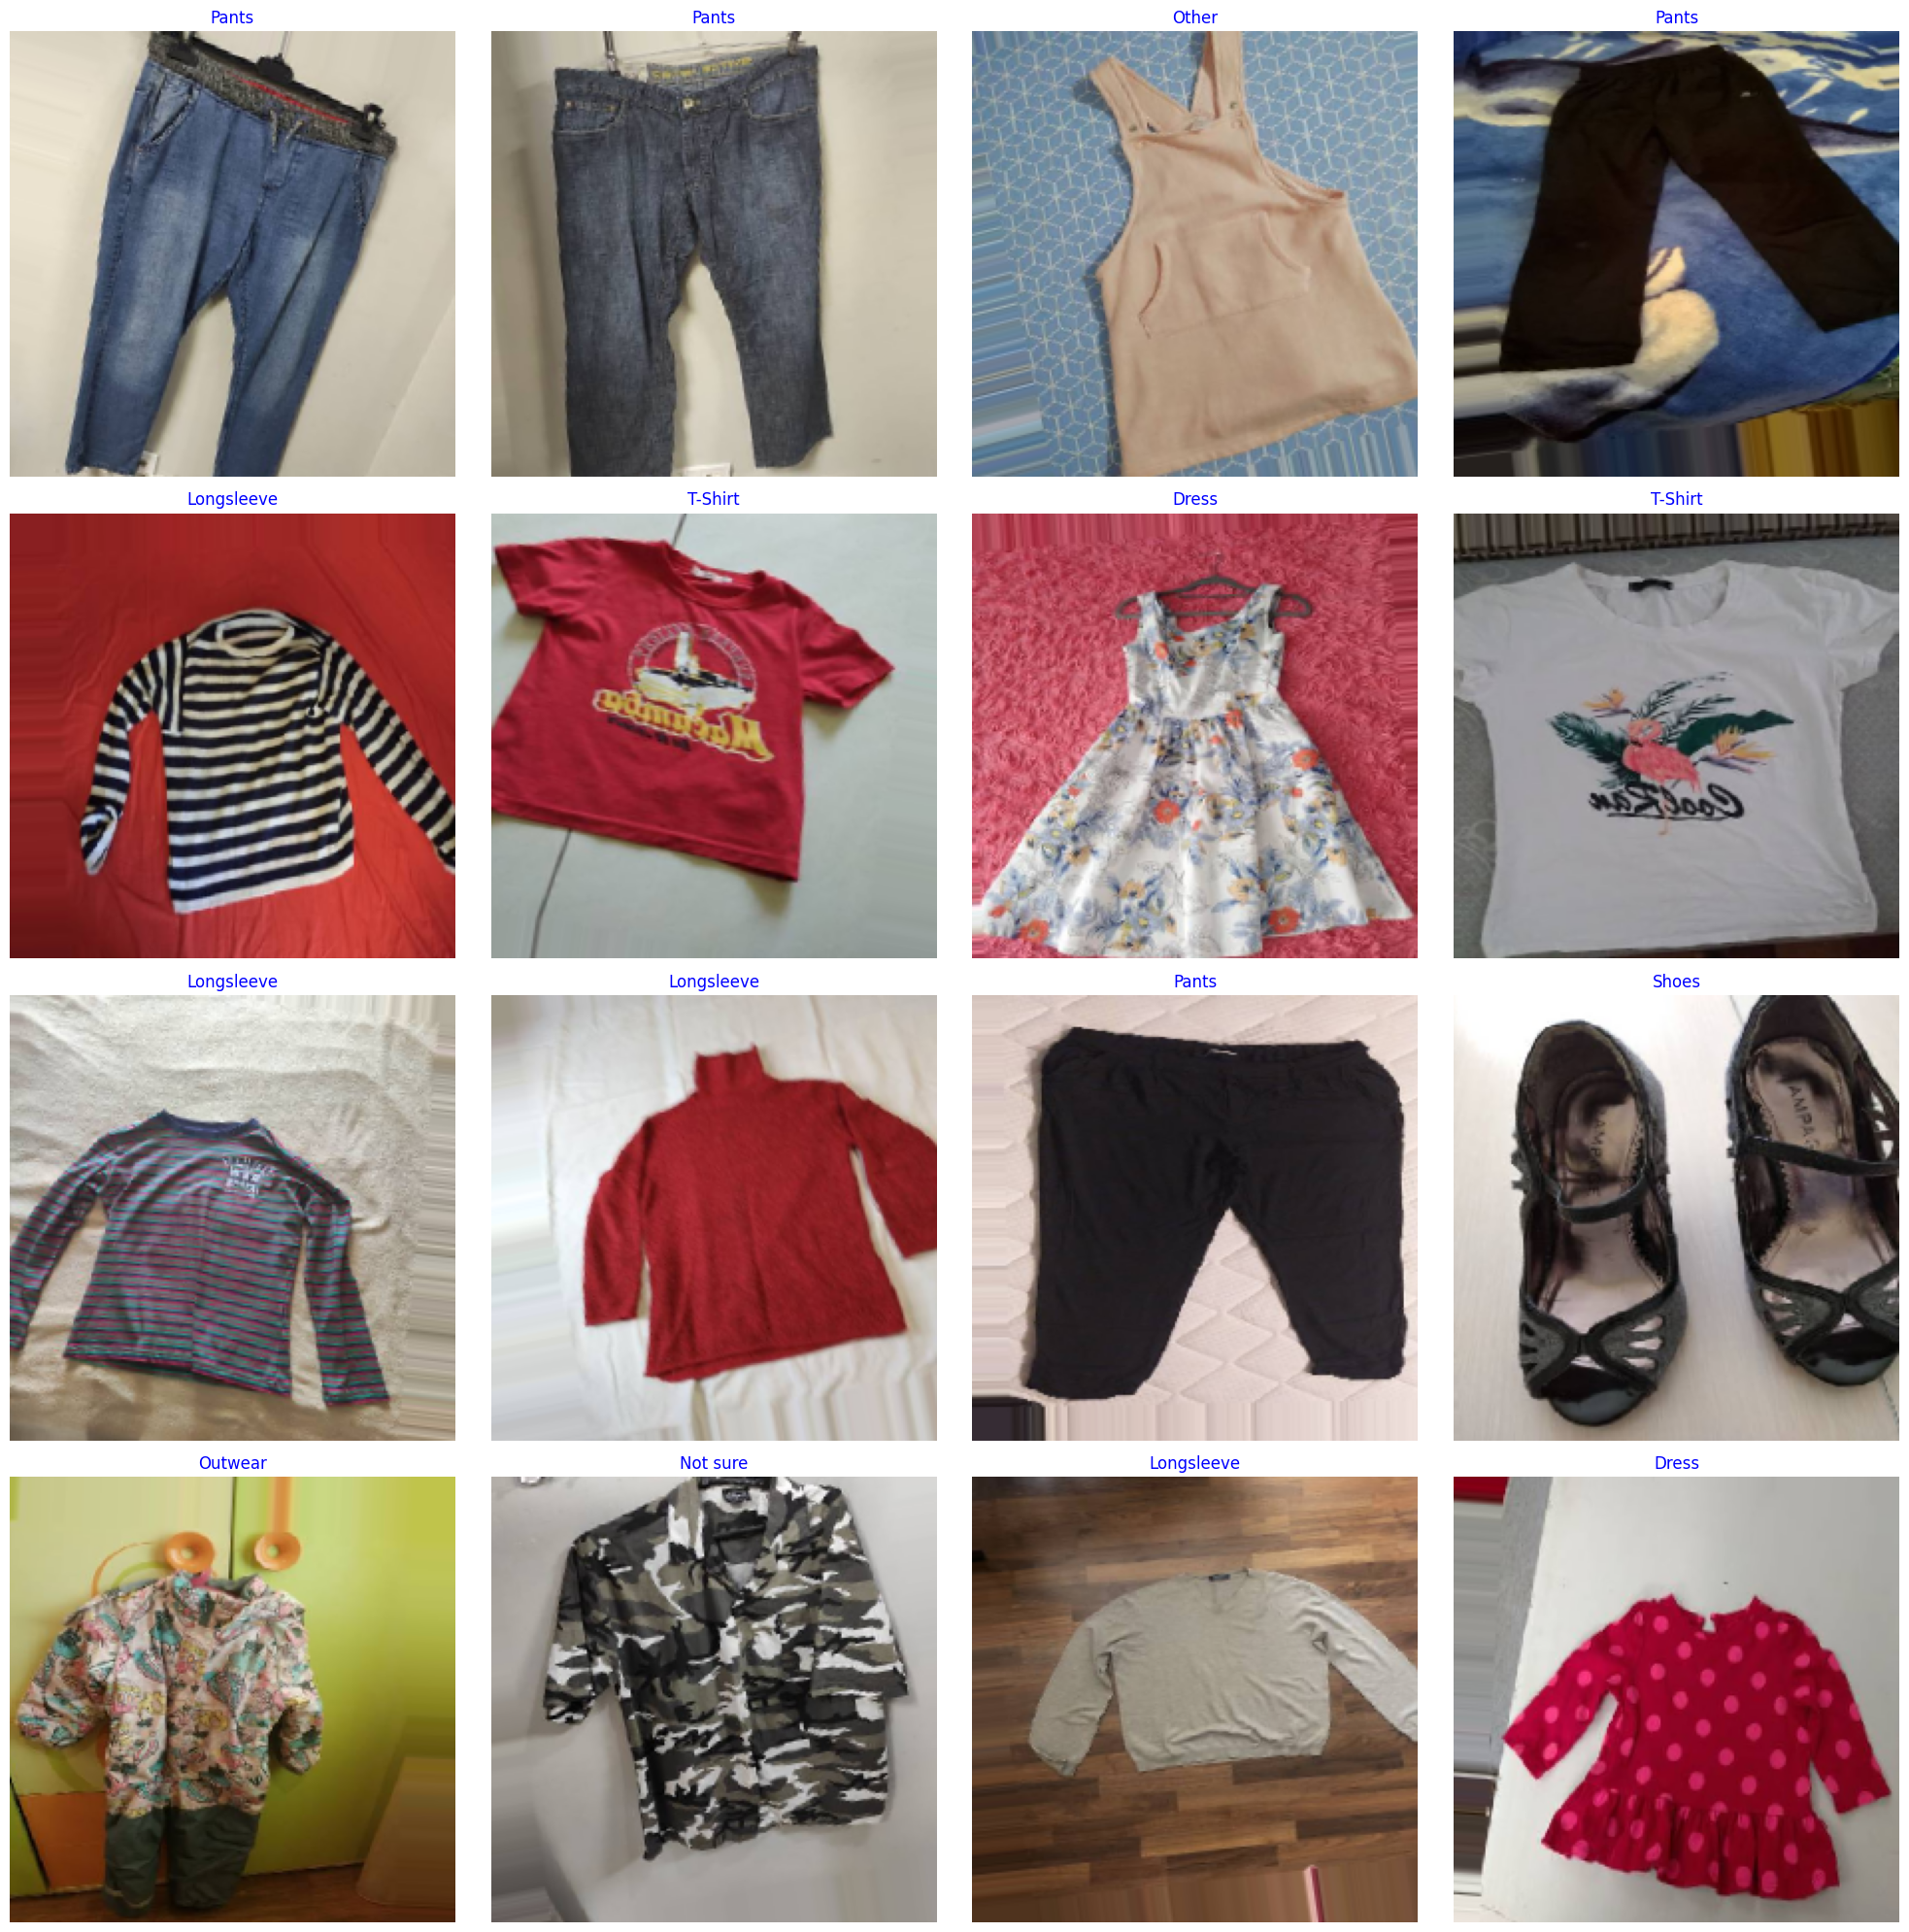

In [10]:
gen_dict = train_generator.class_indices
classes_name = list(gen_dict.keys())

images, labels = next(train_generator)

plt.figure(figsize=(20, 20))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i].squeeze()
    plt.imshow(image) 
    index = np.argmax(labels[i]) 
    class_name = classes_name[index]  
    plt.title(class_name, color='blue', fontsize=12)
    plt.axis('off')


plt.tight_layout()
plt.show()

# **Main functions**

## Metrics

In [11]:
from keras import backend as K

def f1(y_true, y_pred):
    precision_m = precision(y_true, y_pred)
    recall_m = recall(y_true, y_pred)
    return 2*((precision_m*recall_m)/(precision_m+recall_m+K.epsilon()))

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def auc(y_true, y_pred):
    pos = K.sum(y_true, axis=0)
    neg = K.sum(1 - y_true, axis=0)

    tp = K.sum(y_true * y_pred, axis=0)
    fp = K.sum((1 - y_true) * y_pred, axis=0)
    
    tpr = tp / (pos + K.epsilon())
    fpr = fp / (neg + K.epsilon())
    auc = (1 - fpr + tpr) / 2

    return K.mean(auc)

## Evaluation

In [12]:

ts_length = len(test_df)
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length % n == 0 and ts_length / n <= 80]))
test_steps = ts_length // test_batch_size

def evaluate_model(model, training_generator, valid_generator=validation_generator, test_generator=test_generator, test_steps=test_steps):
    train_score = model.evaluate(training_generator, steps=test_steps, verbose=1)
    valid_score = model.evaluate(valid_generator, steps=test_steps, verbose=1)
    test_score = model.evaluate(test_generator, steps=test_steps, verbose=1)
    
    print("Train Loss: ", train_score[0])
    print("Train Accuracy: ", train_score[1])
    print('-' * 20)
    print("Valid Loss: ", valid_score[0])
    print("Valid Accuracy: ", valid_score[1])
    print('-' * 20)
    print("Test Loss: ", test_score[0])
    print("Test Accuracy: ", test_score[1])

## Predictions

In [13]:
def show_predictions(model, test_generator, class_indices, num_images=5):
    class_labels = {v: k for k, v in class_indices.items()}
    
    test_images, test_labels = next(test_generator)
    
    predictions = model.predict(test_images)
    predicted_labels = np.argmax(predictions, axis=1)
    
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(test_images[i])
        true_label = class_labels[np.argmax(test_labels[i])]
        predicted_label = class_labels[predicted_labels[i]]
        plt.title(f"True: {true_label}\nPred: {predicted_label}")
        plt.axis('off')
    plt.show()

# **Modeling**

## VGG

In [14]:
base_model_vgg = tf.keras.applications.VGG19(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)
)
base_model_vgg.trainable = False

In [15]:
NAME = f"clothing-dataset-vgg-{int(time.time())}"
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=f"../working/logs/{NAME}")

vgg = tf.keras.Sequential(
    layers=[
        tf.keras.layers.InputLayer(next(train_generator)[0][0].shape),

        base_model_vgg,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),

        tf.keras.layers.Dense(next(train_generator)[1][0].shape[0], activation='softmax')  
    ],
    name=NAME
)

vgg.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy', f1, auc])

vgg.summary()

Model: "clothing-dataset-vgg-1717709181"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                   

In [16]:
history_vgg = vgg.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[tensorboard]
)

Epoch 1/10
135/135 [==============================] - 83s 530ms/step - loss: 2.3548 - accuracy: 0.4094 - f1: 0.3930 - auc: 0.5676 - val_loss: 2.2308 - val_accuracy: 0.3210 - val_f1: 0.0000e+00 - val_auc: 0.5120
Epoch 2/10
135/135 [==============================] - 79s 584ms/step - loss: 1.5563 - accuracy: 0.5505 - f1: 0.5470 - auc: 0.6126 - val_loss: 1.5559 - val_accuracy: 0.6067 - val_f1: 0.3371 - val_auc: 0.5632
Epoch 3/10
135/135 [==============================] - 79s 582ms/step - loss: 1.3349 - accuracy: 0.6059 - f1: 0.5930 - auc: 0.6286 - val_loss: 1.1599 - val_accuracy: 0.6494 - val_f1: 0.6002 - val_auc: 0.6126
Epoch 4/10
135/135 [==============================] - 79s 584ms/step - loss: 1.2318 - accuracy: 0.6265 - f1: 0.6184 - auc: 0.6383 - val_loss: 1.0669 - val_accuracy: 0.6698 - val_f1: 0.6584 - val_auc: 0.6378
Epoch 5/10
135/135 [==============================] - 79s 585ms/step - loss: 1.1253 - accuracy: 0.6606 - f1: 0.6463 - auc: 0.6469 - val_loss: 1.0398 - val_accuracy: 0.6

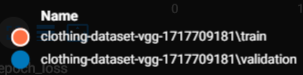

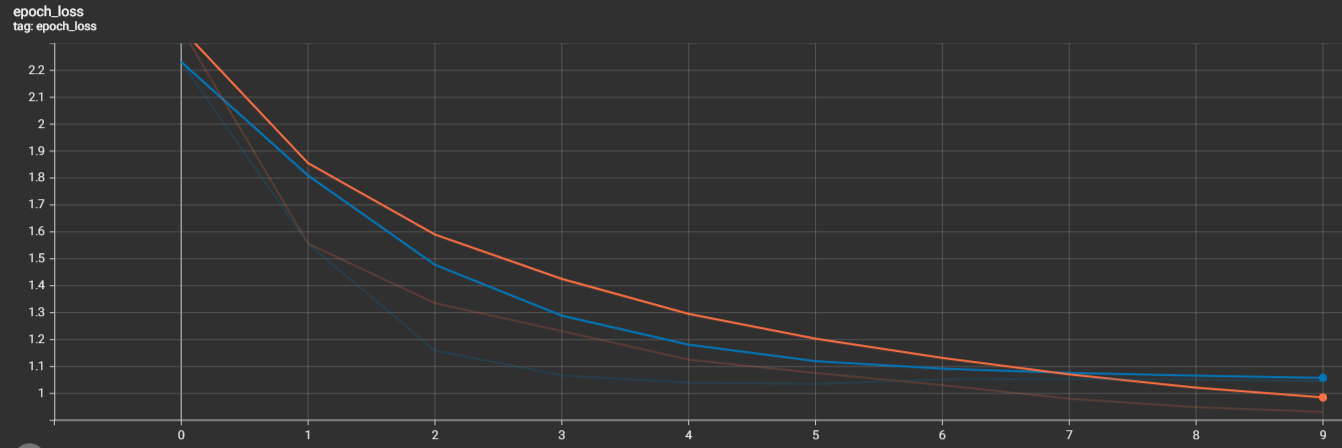
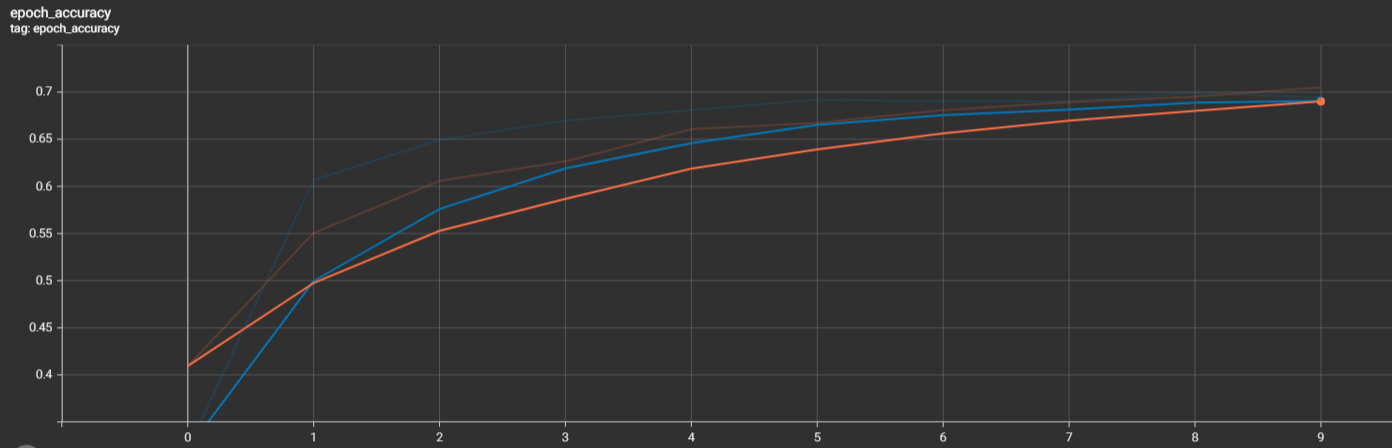
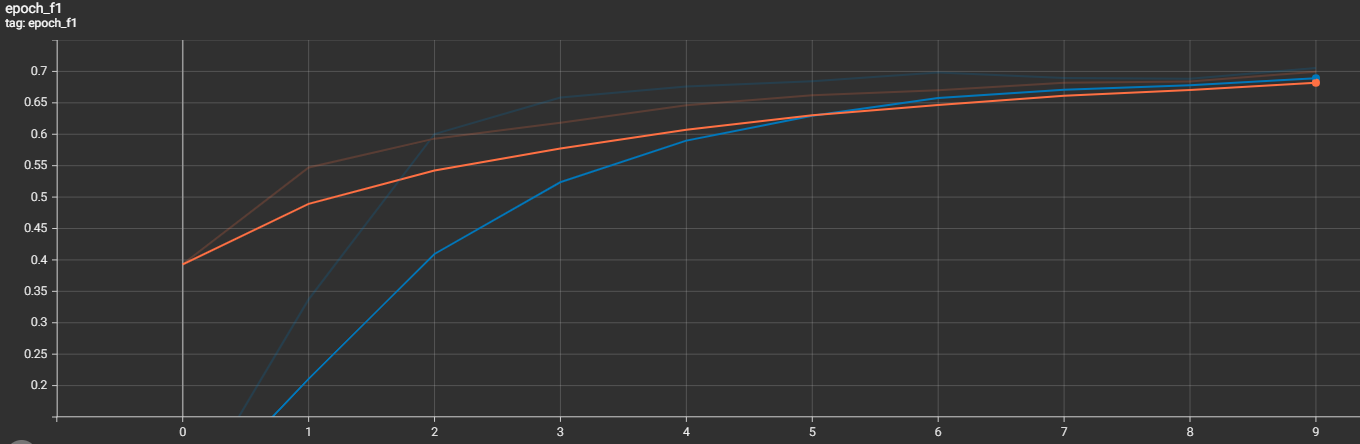
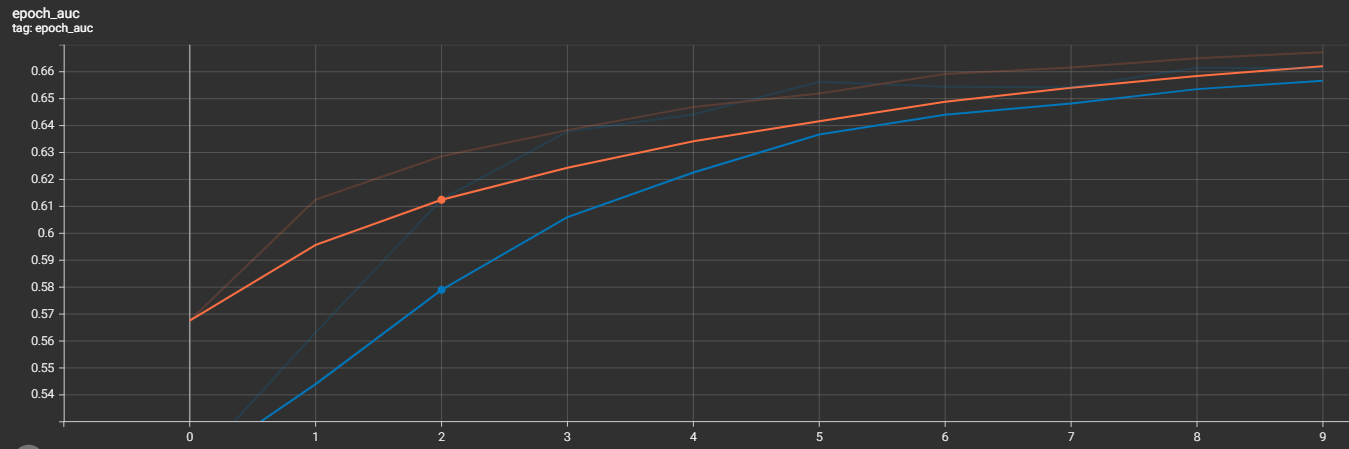

### Evaluation

In [17]:
evaluate_model(vgg, train_generator)

9/9 [==============================] - 5s 522ms/step - loss: 1.0707 - accuracy: 0.6840 - f1: 0.7149 - auc: 0.6810
Train Loss:  0.5671209096908569
Train Accuracy:  0.8333333134651184
--------------------
Valid Loss:  1.0515742301940918
Valid Accuracy:  0.6840277910232544
--------------------
Test Loss:  1.0706729888916016
Test Accuracy:  0.6840277910232544


1/1 [==============================] - 0s 228ms/step


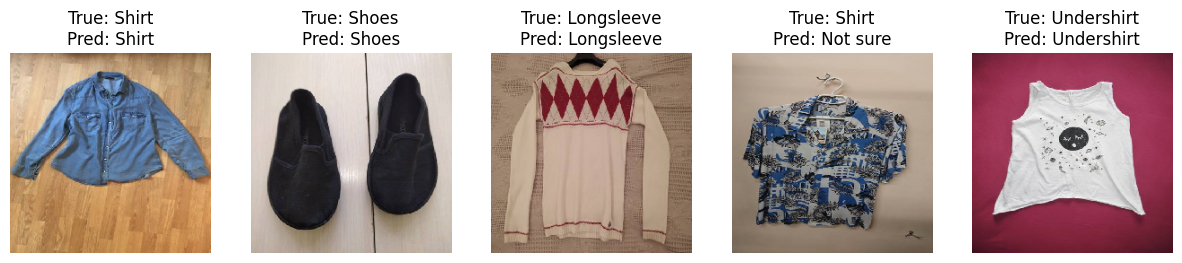

In [18]:
show_predictions(vgg, test_generator, test_generator.class_indices)

## Inception

In [19]:
base_model_inception = tf.keras.applications.InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3))

base_model_inception.trainable = False

In [20]:
NAME = f"clothing-dataset-inception-{int(time.time())}"
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=f"../working/logs/{NAME}")

inception = tf.keras.Sequential(
    layers=[
        tf.keras.layers.InputLayer(next(train_generator)[0][0].shape),

        base_model_inception,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),

        tf.keras.layers.Dense(next(train_generator)[1][0].shape[0], activation='softmax')  
    ],
    name=NAME
)

inception.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy', f1, auc])

inception.summary()

Model: "clothing-dataset-inception-1717710010"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_96 (Bat  (None, 2048)             8192      
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 256)               524544    
                                                                 
 batch_normalization_97 (Bat  (None, 256)              1024      
 chNormalization)                                                
                             

In [21]:
history_inception = inception.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[tensorboard]
)

Epoch 1/10
135/135 [==============================] - 69s 451ms/step - loss: 1.6665 - accuracy: 0.5621 - f1: 0.5613 - auc: 0.6263 - val_loss: 1.0344 - val_accuracy: 0.6735 - val_f1: 0.6561 - val_auc: 0.6470
Epoch 2/10
135/135 [==============================] - 52s 387ms/step - loss: 1.1649 - accuracy: 0.6527 - f1: 0.6569 - auc: 0.6606 - val_loss: 0.9382 - val_accuracy: 0.7161 - val_f1: 0.7157 - val_auc: 0.6704
Epoch 3/10
135/135 [==============================] - 53s 392ms/step - loss: 1.0382 - accuracy: 0.6857 - f1: 0.6833 - auc: 0.6673 - val_loss: 0.8882 - val_accuracy: 0.7254 - val_f1: 0.7214 - val_auc: 0.6710
Epoch 4/10
135/135 [==============================] - 49s 360ms/step - loss: 0.9273 - accuracy: 0.7163 - f1: 0.7117 - auc: 0.6720 - val_loss: 0.8802 - val_accuracy: 0.7403 - val_f1: 0.7426 - val_auc: 0.6871
Epoch 5/10
135/135 [==============================] - 47s 345ms/step - loss: 0.8595 - accuracy: 0.7418 - f1: 0.7361 - auc: 0.6843 - val_loss: 0.8571 - val_accuracy: 0.7458 

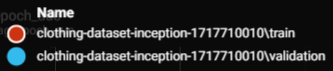

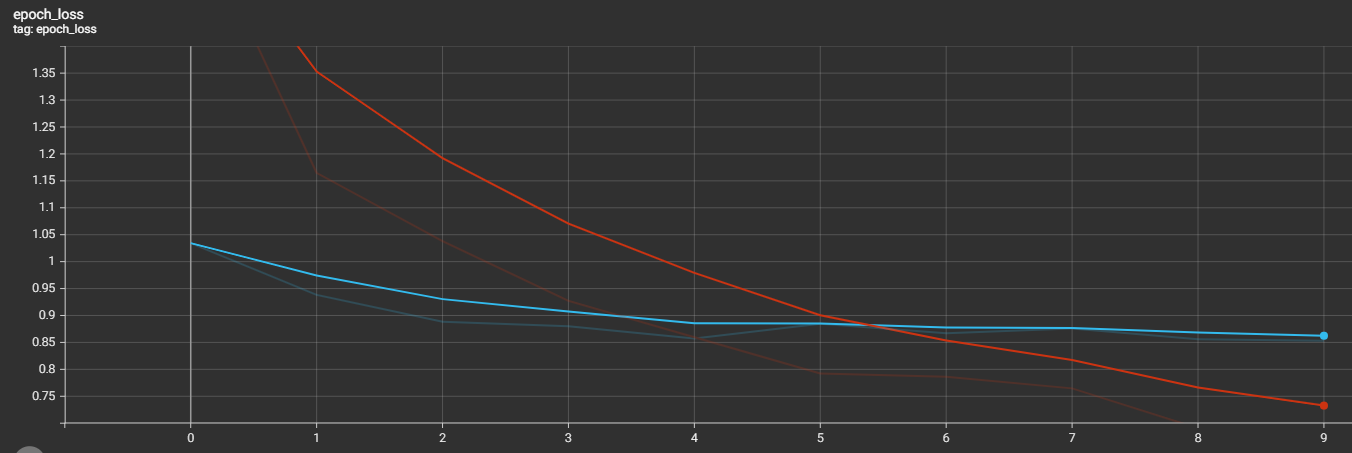
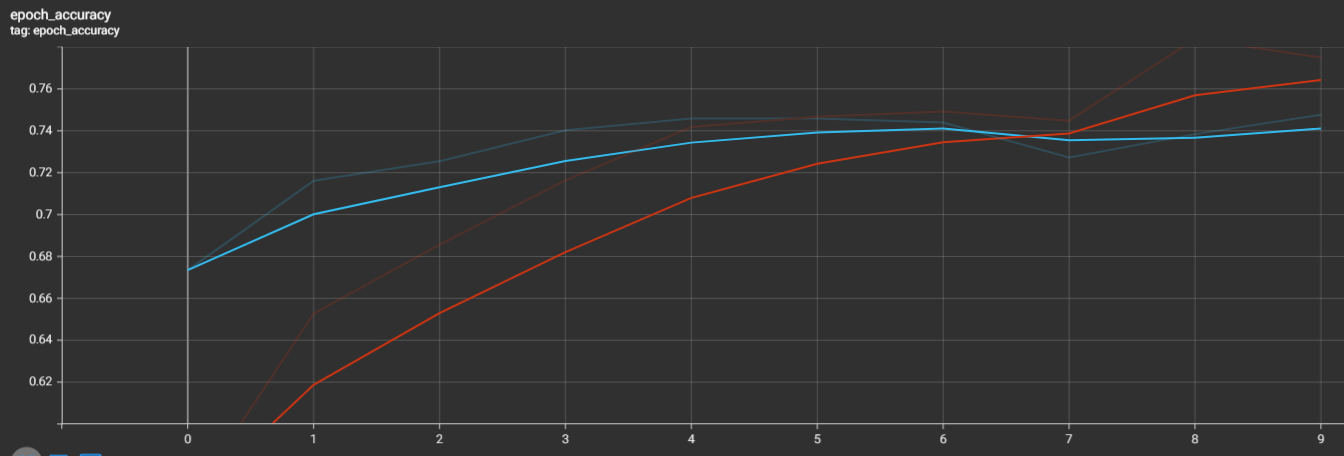
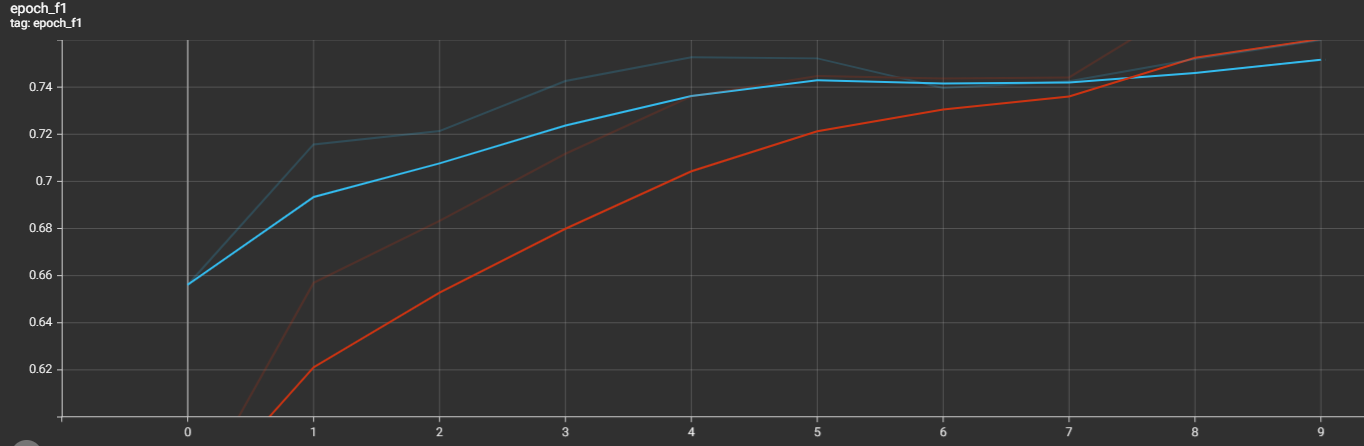
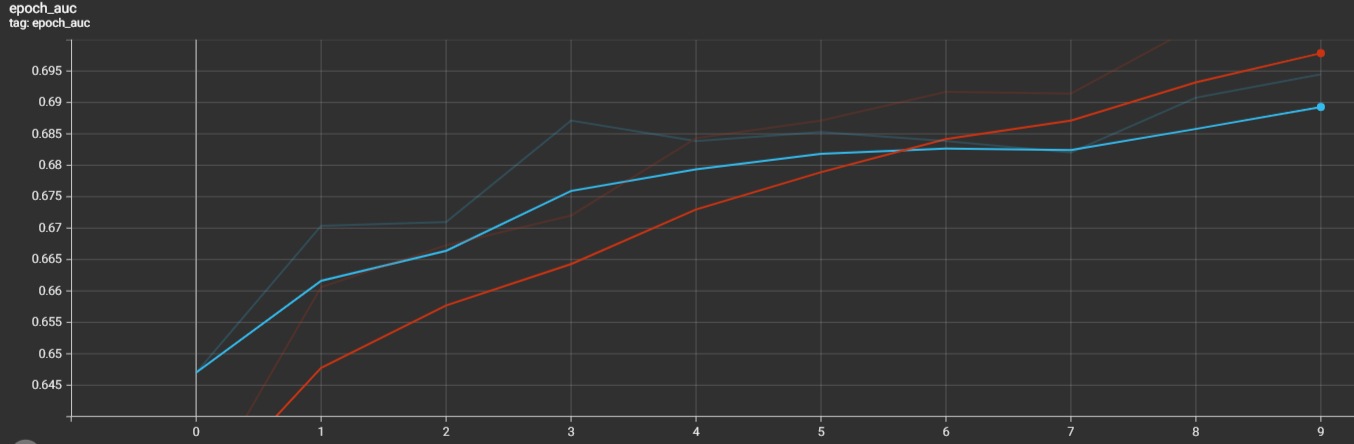

### Evaluation

In [22]:
evaluate_model(inception, train_generator)

9/9 [==============================] - 2s 177ms/step - loss: 0.8287 - accuracy: 0.7604 - f1: 0.7603 - auc: 0.7005
Train Loss:  0.5208255648612976
Train Accuracy:  0.8472222089767456
--------------------
Valid Loss:  0.8746408820152283
Valid Accuracy:  0.7430555820465088
--------------------
Test Loss:  0.8286855816841125
Test Accuracy:  0.7604166865348816


1/1 [==============================] - 1s 1s/step


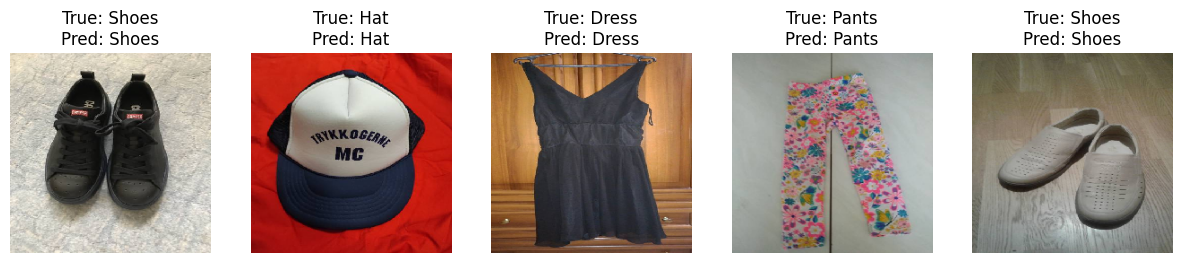

In [23]:
show_predictions(inception, test_generator, test_generator.class_indices)

## DenseNet

In [24]:
base_model_densenet = tf.keras.applications.DenseNet201(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
    )

base_model_densenet.trainable = False

74836368/74836368 [==============================] - 7s 0us/step


In [25]:
NAME = f"clothing-dataset-densenet-{int(time.time())}"
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=f"../working/logs/{NAME}")

densenet = tf.keras.Sequential(
    layers=[
        tf.keras.layers.InputLayer(next(train_generator)[0][0].shape),

        base_model_densenet,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),

        tf.keras.layers.Dense(next(train_generator)[1][0].shape[0], activation='softmax')  
    ],
    name=NAME
)

densenet.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy', f1, auc])

densenet.summary()

Model: "clothing-dataset-densenet-1717710535"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d_2   (None, 1920)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 batch_normalization_98 (Bat  (None, 1920)             7680      
 chNormalization)                                                
                                                                 
 dense_4 (Dense)             (None, 256)               491776    
                                                                 
 batch_normalization_99 (Bat  (None, 256)              1024      
 chNormalization)                                                
                              

In [26]:
history_densenet = densenet.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[tensorboard]
)

Epoch 1/10
135/135 [==============================] - 86s 521ms/step - loss: 1.6593 - accuracy: 0.5676 - f1: 0.5653 - auc: 0.6240 - val_loss: 0.8469 - val_accuracy: 0.7625 - val_f1: 0.7323 - val_auc: 0.6608
Epoch 2/10
135/135 [==============================] - 57s 417ms/step - loss: 0.9475 - accuracy: 0.7191 - f1: 0.7164 - auc: 0.6743 - val_loss: 0.7427 - val_accuracy: 0.7829 - val_f1: 0.7825 - val_auc: 0.6923
Epoch 3/10
135/135 [==============================] - 59s 435ms/step - loss: 0.7966 - accuracy: 0.7520 - f1: 0.7528 - auc: 0.6935 - val_loss: 0.7197 - val_accuracy: 0.7922 - val_f1: 0.7884 - val_auc: 0.7017
Epoch 4/10
135/135 [==============================] - 59s 437ms/step - loss: 0.6915 - accuracy: 0.7817 - f1: 0.7849 - auc: 0.7046 - val_loss: 0.7132 - val_accuracy: 0.7885 - val_f1: 0.7947 - val_auc: 0.7059
Epoch 5/10
135/135 [==============================] - 60s 440ms/step - loss: 0.5993 - accuracy: 0.8133 - f1: 0.8078 - auc: 0.7177 - val_loss: 0.7369 - val_accuracy: 0.7792 

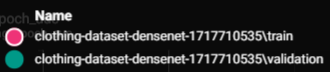

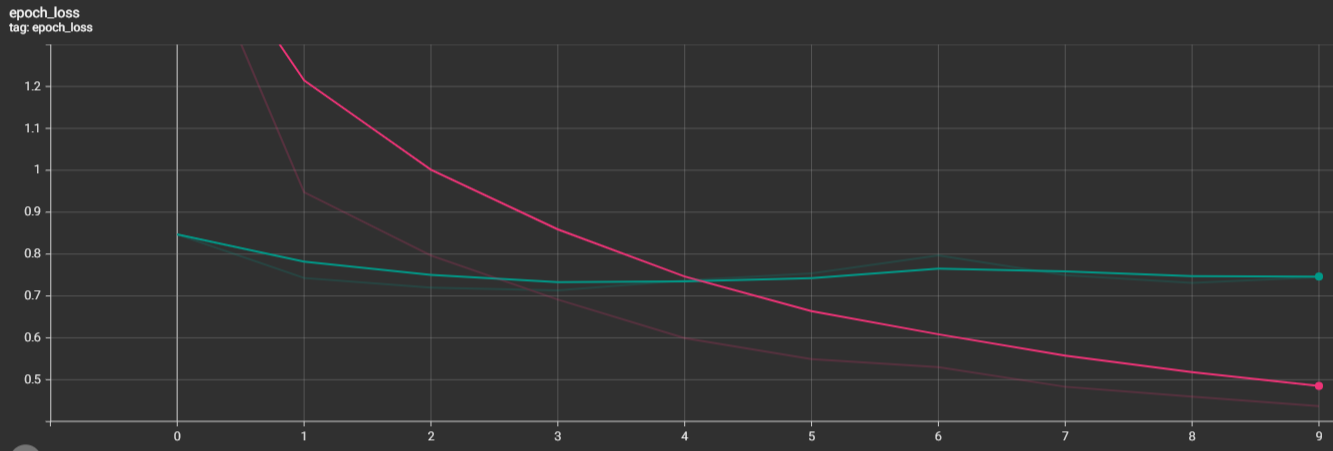
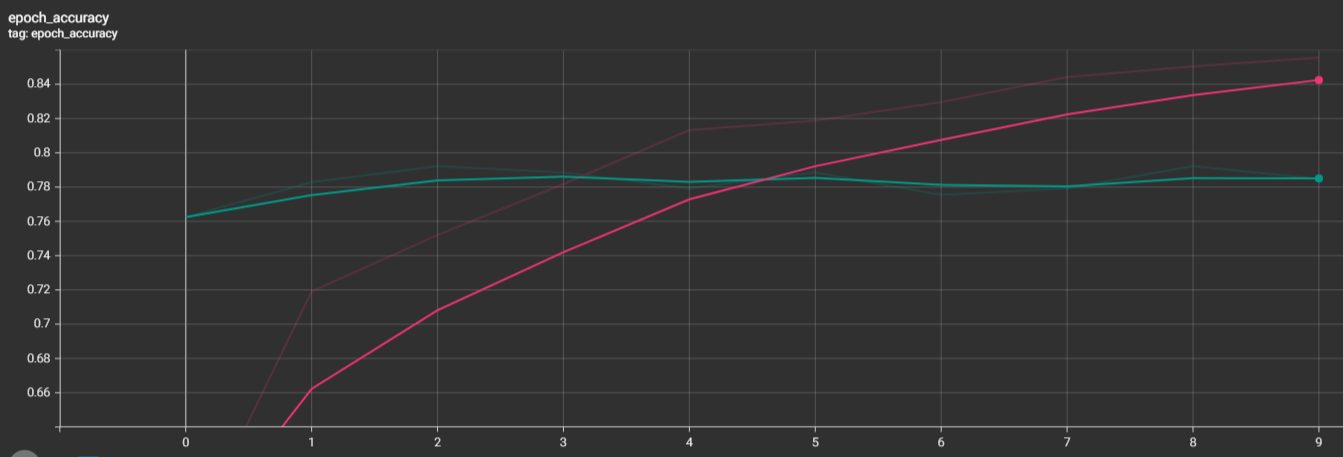
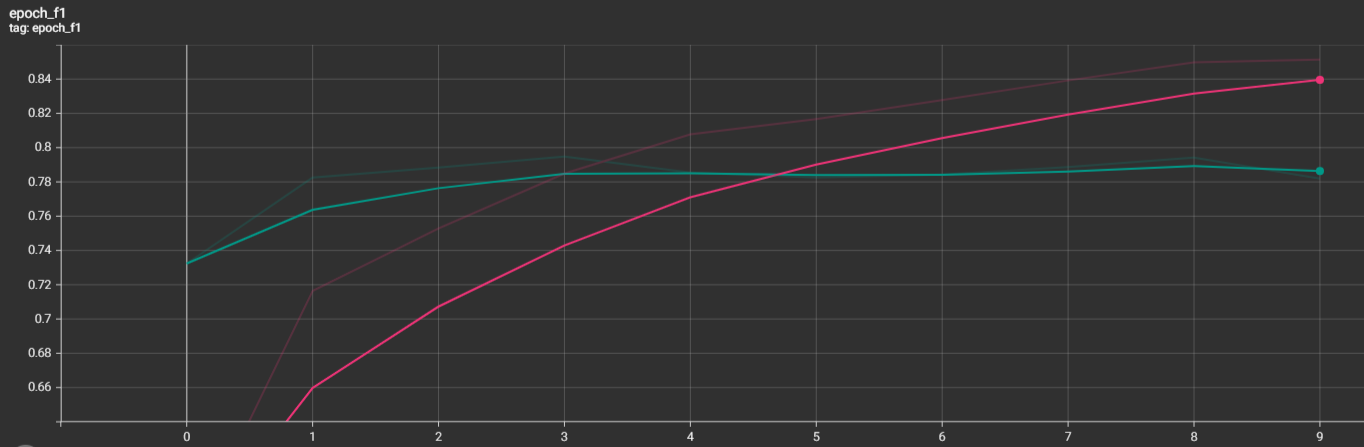
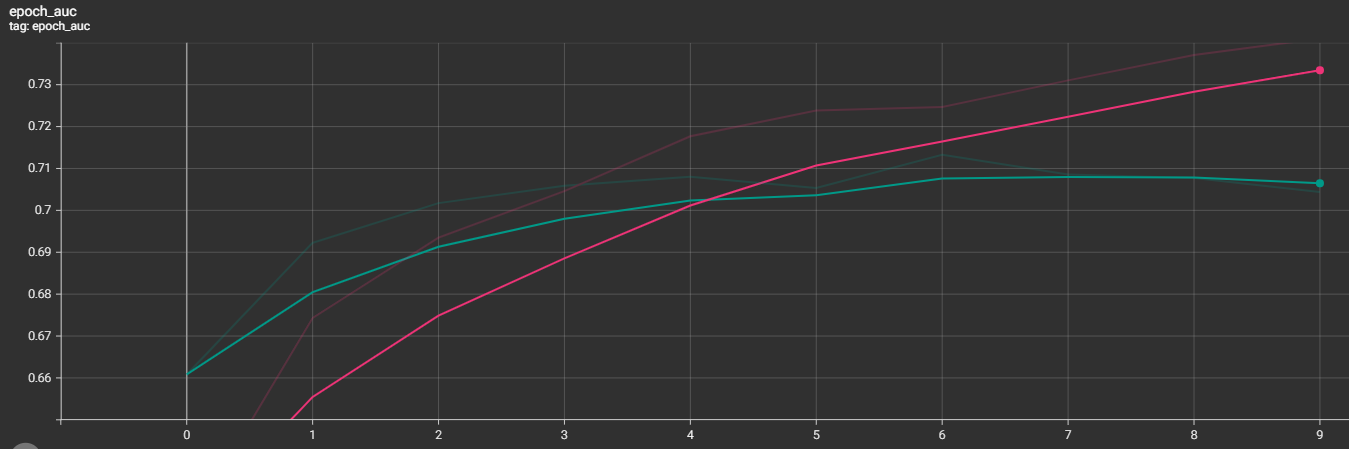

### Evaluation

In [27]:
evaluate_model(inception, train_generator)

9/9 [==============================] - 2s 180ms/step - loss: 0.8647 - accuracy: 0.7535 - f1: 0.7465 - auc: 0.6906
Train Loss:  0.4531092643737793
Train Accuracy:  0.8576388955116272
--------------------
Valid Loss:  0.8405710458755493
Valid Accuracy:  0.7395833134651184
--------------------
Test Loss:  0.8647044897079468
Test Accuracy:  0.7534722089767456


1/1 [==============================] - 0s 38ms/step


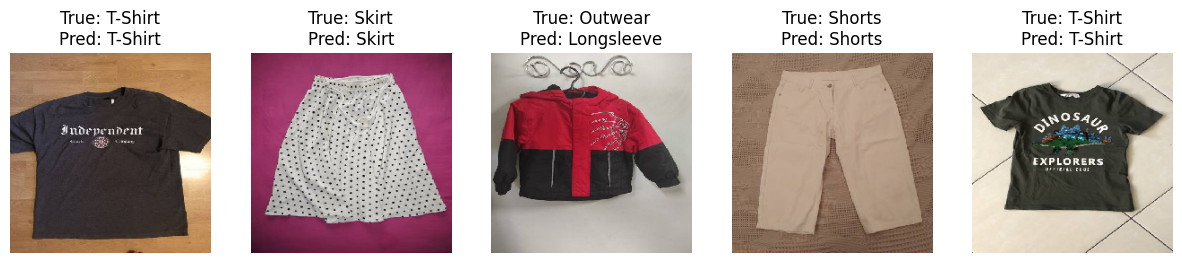

In [28]:
show_predictions(inception, test_generator, test_generator.class_indices)

# **Model Comparison**

Порівняємо моделі із результатами попередньої лабораторної роботи.

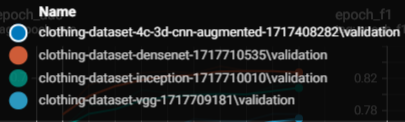

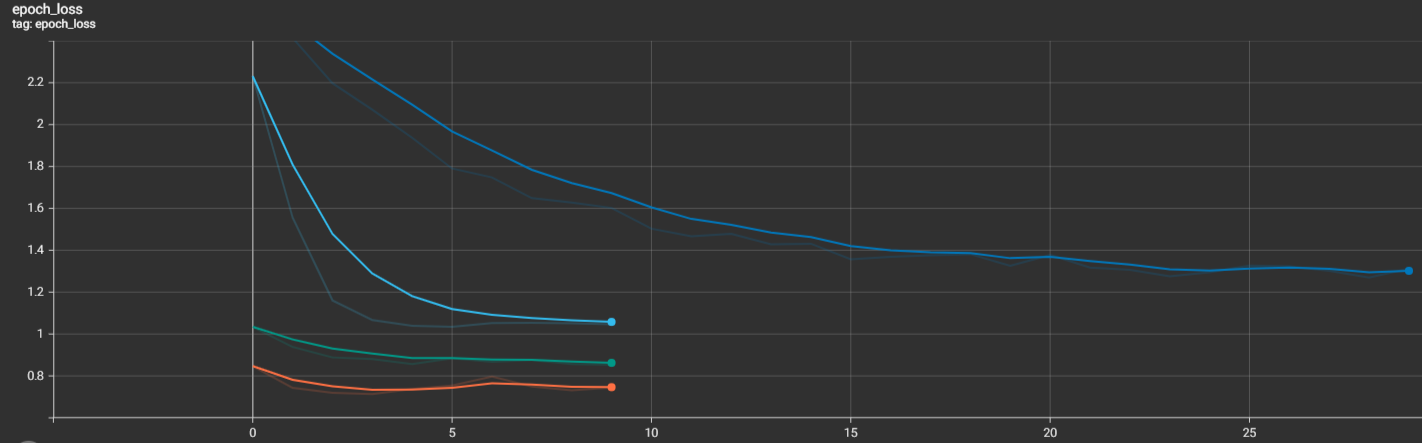
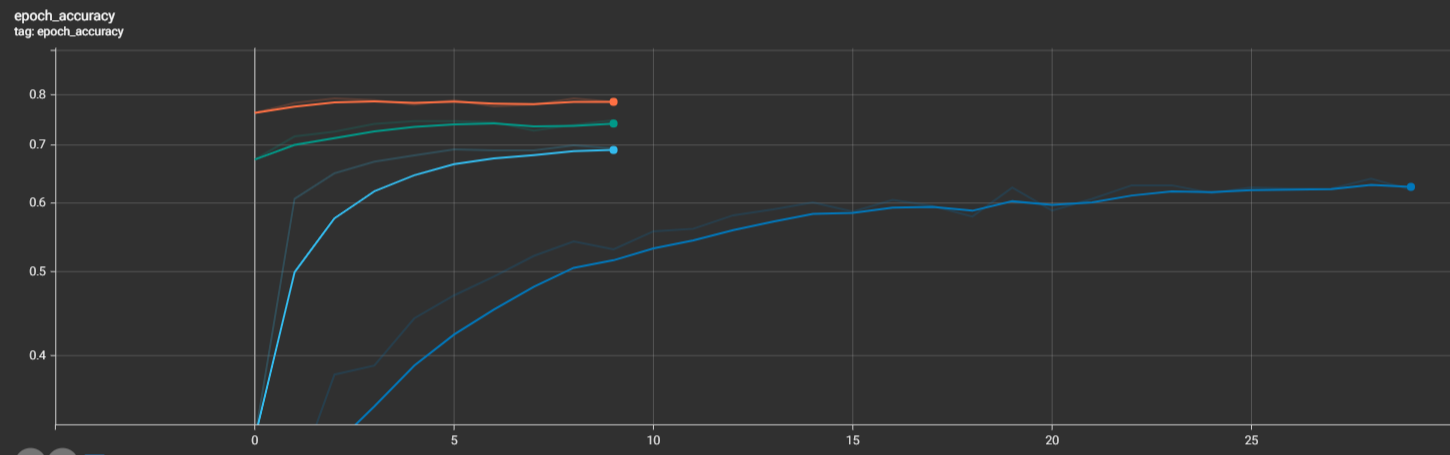

Глобально, розглянуті моделі (особливо inception та densenet) показали дуже схожі результати, які значно перевищують попередню модель по скорах та швидкості їх досягнення.